# Import

In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import nimfa
from functions.utils import *
from functions.plotting import *

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

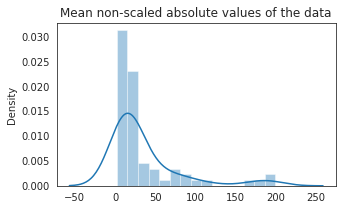

In [9]:
fc = pd.read_csv('/uftp/users/ashchetsova/hackathon/data_90_day.tsv', index_col=0,sep='\t')
anno = pd.read_csv('/uftp/users/ashchetsova/hackathon/total_annotation.tsv', index_col=0,sep='\t')
anno.index = anno.Sample_ID
anno = anno[['ID','cGVHD_development_time', 'cGVHD_development', 'Days','Day_after_transplant']]
anno = anno[~anno.index.duplicated()]
durations = pd.concat([anno[anno.cGVHD_development_time.isna()].ID.map(lambda x:anno[anno.ID==x].Day_after_transplant.max()),anno[~anno.cGVHD_development_time.isna()].cGVHD_development_time
                      ])
events = fc.GVHD_status
durations = durations.reindex(events.index)

fc = fc.drop(columns = ['patient', 'day', 'GVHD_status',
       'GVHD_day'])

fig,ax=plt.subplots(figsize=(5,3))
sns.distplot(fc.T.mean(),ax=ax)
plt.title('Mean non-scaled absolute values of the data')
plt.savefig('plots/eda_distplot_non_scaled.png',dpi=300, bbox_inches='tight')

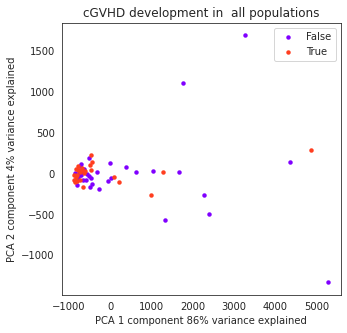

In [10]:
pca_plot(fc, events)
plt.title('cGVHD development in  all populations')
plt.savefig('plots/eda_pca_plot_non_scaled.png',dpi=300, bbox_inches='tight')

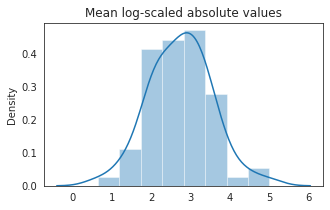

In [11]:
fc = np.log2(fc+1)
fig,ax=plt.subplots(figsize=(5,3))
sns.distplot(fc.T.mean(),ax=ax)
plt.title('Mean log-scaled absolute values')
plt.savefig('plots/eda_distplot_log_scaled.png',dpi=300, bbox_inches='tight')

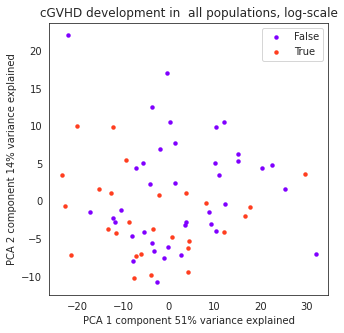

In [12]:
pca_plot(fc, events)
plt.title('cGVHD development in  all populations, log-scale')
plt.savefig('plots/eda_pca_plot_log_scaled.png',dpi=300, bbox_inches='tight')

In [15]:
iterative_pca_outliers(fc)

There are no outliers


[]

## Potential dupes drop

Index(['CD4+ EMTM maturity and None expression', 'CD4+ EM maturity and CD226+ expression'], dtype='object') 0
Index(['CD8+ EMTM maturity and None expression', 'CD8+ EMTM maturity and CD226+ expression'], dtype='object') 0
Index(['CD4+ EM maturity and PD-1+TIGIT+ expression', 'CD4+ EM maturity and TIGIT+ expression'], dtype='object') 3
Index(['CD8+ CM maturity and PD-1+TIGIT+ expression', 'CD8+ CM maturity and PD1+ expression'], dtype='object') 1
Index(['CD4+ None maturity and TIGIT+ expression', 'CD4+ None maturity and PD-1+TIGIT+ expression'], dtype='object') 13
Index(['CD8+ None maturity and PD-1-TIGIT+ expression', 'CD8+ TE maturity and PD-1-TIGIT+ expression'], dtype='object') 0
Index(['Treg None maturity and CD226+TIGIT+ expression', 'Treg None maturity and CD226+ expression'], dtype='object') 1
Index(['CD4+ CM maturity and TIGIT+ expression', 'CD4+ CM maturity and PD-1+TIGIT+ expression'], dtype='object') 8
Index(['CD4+ NV maturity and PD-1-TIGIT- expression', 'CD4+ NV maturity a

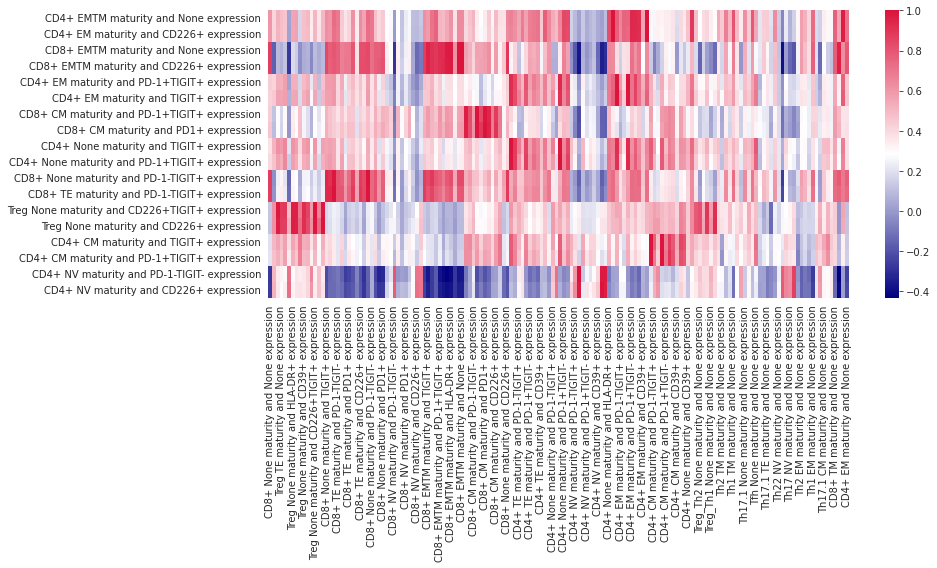

In [13]:
thr = 0.1
corrs = fc.corr(method='spearman').loc[fc.corr(method='spearman')[fc.corr(method='spearman')!=1].max().sort_values(ascending=False).index]
potential_corrs = []
similarity = []
start = 0
for i in range(2,len(corrs.index),2):
    cut = corrs[start:i]
    start = i
    cls = cut.columns.map(lambda x: 0 if np.isclose(cut[x].iloc[0],cut[x].iloc[1],atol=0.05,) else 1)
    similarity.append(np.mean(cls))
    if np.mean(cls)<thr:
        print(cut.index, np.sum(cls))
        potential_corrs+=cut.index.to_list()

plt.figure(figsize=(14,8))
sns.heatmap(corrs.loc[potential_corrs], cmap = default_cmap)
plt.tight_layout()
plt.savefig('plots/potential_dupes_tight.png',dpi=300, bbox_inches='tight')

In [14]:
to_drop = ['Th22 EM maturity and None expression', # high variability or potentially below lod
 'Th17.1 NV maturity and None expression',
 'Th22 CM maturity and None expression',
 'Th17 TE maturity and None expression',
 'Th1 EM maturity and None expression',
 'Th17.1 CM maturity and None expression',
 'CD8+ EMTM maturity and PD-1-TIGIT- expression',
 'Th17.1 TE maturity and None expression',
 'CD8+ EMTM maturity and PD-1-TIGIT+ expression',
 'Treg_Th1 None maturity and None expression',
 'CD8+ EMTM maturity and PD1+ expression',
 'Treg_Th17.1 None maturity and None expression',
 'Th17 EM maturity and None expression',
 'CD8+ EM maturity and None expression',
 'Treg None maturity and CD226+TIGIT- expression',
 'Th22 TE maturity and None expression',
 'Th17.1 EM maturity and None expression',
 'CD8+ EMTM maturity and CD39+ expression',
 'Th22 NV maturity and None expression',
 'Th17 NV maturity and None expression',
 'CD4+ EM maturity and None expression',
 'CD8+ EMTM maturity and PD-1+TIGIT+ expression','Th2 TE maturity and None expression', 'Th2 EM maturity and None expression']+['CD4+ EMTM maturity and None expression',# potentially dupes
 'CD8+ EMTM maturity and None expression',
 'CD4+ EM maturity and TIGIT+ expression',
 'CD8+ CM maturity and PD1+ expression',
 'CD4+ None maturity and TIGIT+ expression',
 'CD8+ None maturity and PD-1-TIGIT+ expression',
 'Treg None maturity and CD226+ expression',
 'CD4+ CM maturity and TIGIT+ expression']

fc = fc.drop(columns = to_drop)

# Feature engineering 

In [73]:
populations_united = {'active_t_cells':fc.columns[fc.columns.str.match('.*CD226\+(?!.*TIGIT\+).*')].to_list()+fc.columns[fc.columns.str.match('.*HLA-DR\+.*')].to_list(), 
                     'supressed_t_cells':fc.columns[fc.columns.str.match('.*CD39\+')].to_list()+fc.columns[fc.columns.str.match('.*PD1\+')].to_list()+fc.columns[fc.columns.str.match('.*TIGIT\+(?!.*CD226\+)')].to_list(),
                      'cd4_t_cells':fc.columns[fc.columns.str.match('(?!.*CD8\+)')].to_list(),
                      'cd8_t_cells':fc.columns[fc.columns.str.match('CD8\+.*')].to_list(),
                      'th17':fc.columns[fc.columns.str.match('Th17.*')].to_list()
                     }

populations_united = {i: GeneSet(i,'',populations_united[i]) for i in populations_united.keys()}

In [74]:
populations_united = ssgsea_formula(fc, populations_united)
populations_united.head()

,active_t_cells,supressed_t_cells,cd4_t_cells,cd8_t_cells,th17
48_90,34.720825,20.834527,40.761816,37.917927,3.111532
53_90,34.622410,26.407950,39.304759,40.094525,-1.203149
52_90,32.522661,27.688931,39.262973,40.977506,-4.737012
60_90,31.192386,30.589350,41.487603,36.022779,-19.615181
1_90,35.117313,27.758291,47.580448,25.253452,-1.457907


In [75]:
populations_united['active_to_suppressed_t_cells'] = populations_united.active_t_cells/populations_united.supressed_t_cells
populations_united['cd4_to_cd8_t_cells'] = populations_united.cd4_t_cells/populations_united.cd4_t_cells/populations_united.cd8_t_cells
populations_united['th17_to_cd4_t_cells'] = populations_united.th17/populations_united.cd4_t_cells

populations_united.head()

,active_t_cells,supressed_t_cells,cd4_t_cells,cd8_t_cells,th17,active_to_suppressed_t_cells,cd4_to_cd8_t_cells,th17_to_cd4_t_cells
48_90,34.720825,20.834527,40.761816,37.917927,3.111532,1.666504,0.026373,0.076334
53_90,34.622410,26.407950,39.304759,40.094525,-1.203149,1.311060,0.024941,-0.030611
52_90,32.522661,27.688931,39.262973,40.977506,-4.737012,1.174573,0.024404,-0.120648
60_90,31.192386,30.589350,41.487603,36.022779,-19.615181,1.019714,0.027760,-0.472796
1_90,35.117313,27.758291,47.580448,25.253452,-1.457907,1.265111,0.039599,-0.030641


In [76]:
populations_united = median_scale(populations_united).clip(-4,4)+4

# NMF

## estimating number of clusters

## data w/o engeneering

In [82]:
summary={}
SEED = 42
nmf_data = fc
data = nmf_data
data = np.array(data)

In [241]:
#Sparse NMF
nmf = nimfa.Snmf(data, seed='random_vcol', max_iter=50)

In [198]:
rank_cands = range(2, 40, 1)
summary = nmf.estimate_rank(rank_range=rank_cands, n_run=10, what='all')
summary.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

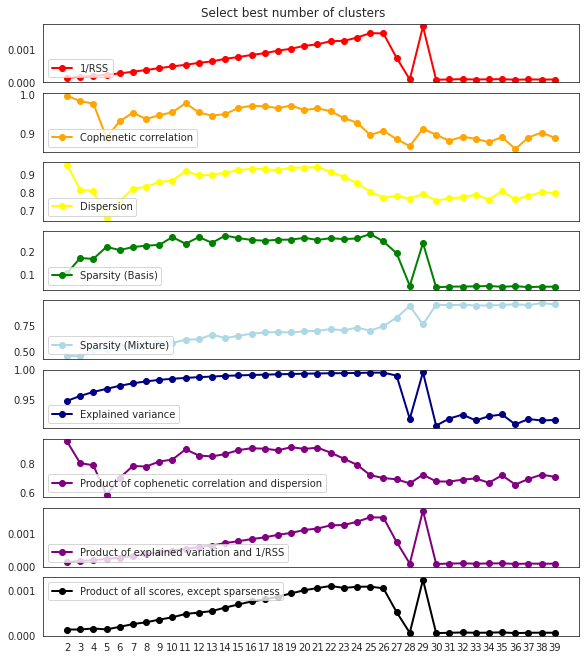

In [199]:
rank_cands = pd.Series(summary.keys())
rss = [1/summary[rank]['rss'] for rank in rank_cands]
coph = [summary[rank]['cophenetic'] for rank in rank_cands]
disp = [summary[rank]['dispersion'] for rank in rank_cands]
spar = [summary[rank]['sparseness'] for rank in rank_cands]
spar_w, spar_h = zip(*spar)
evar = [summary[rank]['evar'] for rank in rank_cands]
multiple_disp_coph = [disp[i]*coph[i] for i in range(len(rank_cands))]
multiple_evar_rss = [evar[i]*rss[i] for i in range(len(rank_cands))]
multiple = [disp[i]*coph[i]*evar[i]*rss[i] for i in range(len(rank_cands))]

af = axis_matras([1]*9,title='Select best number of clusters')

ax= next(af)
ax.plot(rank_cands, rss, 'o-', label='1/RSS', linewidth=2, c='r')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, coph, 'o-', label='Cophenetic correlation', linewidth=2, c='orange')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, disp,'o-', label='Dispersion', linewidth=2,c='yellow')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, spar_w, 'o-', label='Sparsity (Basis)', linewidth=2,c='green')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, spar_h, 'o-', label='Sparsity (Mixture)', linewidth=2,c='lightblue')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, evar, 'o-', label='Explained variance', linewidth=2, c='navy')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, multiple_disp_coph, 'o-', label='Product of cophenetic correlation and dispersion', linewidth=2, c='purple')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, multiple_evar_rss, 'o-', label='Product of explained variation and 1/RSS', linewidth=2, c='purple')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, multiple, 'o-', label='Product of all scores, except sparseness', linewidth=2, c='black')
ax.legend( loc='upper left')
ax.set_xticks(rank_cands)
plt.tight_layout(pad=0.2)

## data w/ engineering

In [86]:
summary={}
SEED = 42
nmf_data = pd.concat([fc,populations_united],axis=1)
data = nmf_data
data = np.array(data)

In [87]:
#Sparse NMF
nmf = nimfa.Snmf(data, seed='random_vcol', max_iter=50)

In [88]:
rank_cands = range(2, 5, 1)
summary = nmf.estimate_rank(rank_range=rank_cands, n_run=10, what='all')
summary.keys()

dict_keys([2, 3, 4])

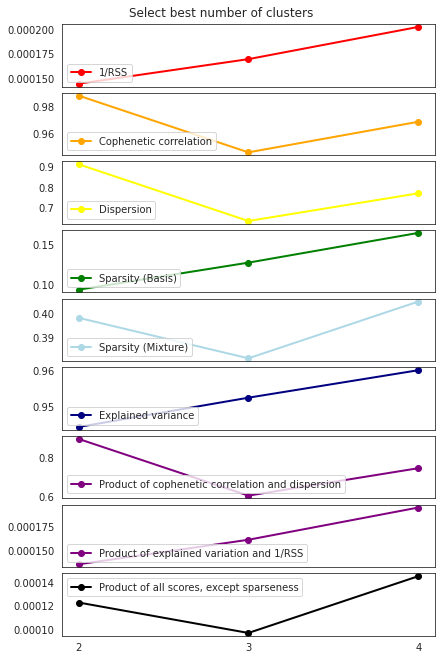

In [111]:
rank_cands = pd.Series(summary.keys())
rss = [1/summary[rank]['rss'] for rank in rank_cands]
coph = [summary[rank]['cophenetic'] for rank in rank_cands]
disp = [summary[rank]['dispersion'] for rank in rank_cands]
spar = [summary[rank]['sparseness'] for rank in rank_cands]
spar_w, spar_h = zip(*spar)
evar = [summary[rank]['evar'] for rank in rank_cands]
multiple_disp_coph = [disp[i]*coph[i] for i in range(len(rank_cands))]
multiple_evar_rss = [evar[i]*rss[i] for i in range(len(rank_cands))]
multiple = [disp[i]*coph[i]*evar[i]*rss[i] for i in range(len(rank_cands))]

af = axis_matras([0.3]*9,6, title='Select best number of clusters',title_y=1)

ax= next(af)
ax.plot(rank_cands, rss, 'o-', label='1/RSS', linewidth=2, c='r')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, coph, 'o-', label='Cophenetic correlation', linewidth=2, c='orange')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, disp,'o-', label='Dispersion', linewidth=2,c='yellow')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, spar_w, 'o-', label='Sparsity (Basis)', linewidth=2,c='green')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, spar_h, 'o-', label='Sparsity (Mixture)', linewidth=2,c='lightblue')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, evar, 'o-', label='Explained variance', linewidth=2, c='navy')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, multiple_disp_coph, 'o-', label='Product of cophenetic correlation and dispersion', linewidth=2, c='purple')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, multiple_evar_rss, 'o-', label='Product of explained variation and 1/RSS', linewidth=2, c='purple')
ax.legend( loc='lower left')

ax= next(af)
ax.plot(rank_cands, multiple, 'o-', label='Product of all scores, except sparseness', linewidth=2, c='black')
ax.legend( loc='upper left')
ax.set_xticks(rank_cands)
plt.tight_layout(pad=0.2)
plt.savefig('plots/nmf_select_cluster_number.png',dpi=300, bbox_inches='tight')

## clustering

In [112]:
import distinctipy

In [135]:
nmf_data

,CD8+ None maturity and None expression,CD4+ None maturity and None expression,Treg None maturity and TIGIT+ expression,Treg TE maturity and None expression,Treg None maturity and PD-1+ expression,Treg NV maturity and None expression,Treg None maturity and HLA-DR+ expression,Treg EMTM maturity and None expression,Treg CM maturity and None expression,Treg None maturity and CD39+ expression,...,CD8+ TM maturity and None expression,CD4+ TM maturity and None expression,active_t_cells,supressed_t_cells,cd4_t_cells,cd8_t_cells,th17,active_to_suppressed_t_cells,cd4_to_cd8_t_cells,th17_to_cd4_t_cells
48_90,10.143849,4.659357,3.560935,1.625284,2.984449,0.896013,3.314037,3.200402,0.582765,2.518109,...,4.854689,6.277094,4.314227,2.764342,3.558056,4.480368,4.551958,5.274939,3.896389,4.585760
53_90,7.606435,3.954196,2.879048,0.605000,2.624764,0.476753,2.613268,2.526629,0.734946,2.775294,...,3.400167,5.264890,4.273201,4.337513,3.177623,4.797905,4.049684,3.901835,3.837372,4.053228
52_90,11.043272,4.226325,3.725850,2.022938,3.347610,0.267148,3.761452,3.531749,0.355818,3.578561,...,5.946933,6.895264,3.397882,4.699087,3.166713,4.926720,3.638305,3.374575,3.815219,3.604887
60_90,3.053392,4.969878,1.282829,0.363599,1.015714,0.349557,1.199168,0.742403,0.418438,1.382738,...,1.256301,2.657774,2.843333,5.517768,3.747557,4.203891,1.906328,2.776345,3.953582,1.851372
1_90,4.272840,6.595505,3.304879,1.145157,2.866109,1.775431,3.396489,3.037534,1.417733,3.242165,...,2.050175,5.481381,4.479511,4.718664,5.338378,2.632788,4.020027,3.724330,4.441575,4.053078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26_90,5.303829,0.005611,0.043224,0.000000,0.057022,0.000000,0.024285,0.063872,0.001020,0.040250,...,0.519991,0.371166,1.955390,4.343572,1.744724,5.939726,5.104542,3.085034,3.669457,5.362793
17_90,3.937961,6.749396,2.696141,2.255158,1.499980,1.606230,1.465105,1.531786,0.390377,2.251069,...,3.176322,5.564514,2.004902,3.736810,5.315056,2.653702,4.751026,3.480024,4.432361,4.711200
23_90,3.453598,6.047823,3.926624,2.637893,2.011487,0.577380,3.153526,3.474386,0.516206,3.663757,...,2.214523,5.819438,0.396504,5.102726,5.536612,2.412874,5.799842,2.196579,4.545196,5.630410
55_90,8.684275,6.070148,4.844288,2.094344,4.274379,2.010522,4.787567,4.418468,2.414730,3.777151,...,5.491055,6.501660,6.009467,2.272559,3.535905,4.454214,2.874527,6.685254,3.901553,2.822596


In [113]:
nmf = nimfa.Snmf(data, seed='random_vcol', max_iter=50,rank=2,
               n_run=1000)

In [114]:
nmf_fit_features = nmf()

In [123]:
basis = pd.DataFrame(data=nmf_fit_features.fit.basis(), index=nmf_data.index)
coef = pd.DataFrame(data=nmf_fit_features.fit.coef().T, index=nmf_data.columns)
feature_cluster = coef.T.idxmax()
feature_cluster.name = 'feature_cluster'
feature_fraction = coef.T.max()/coef.T.sum()
feature_fraction.name = 'feature_fraction'
patient_cluster = basis.T.idxmax()
patient_cluster.name = 'patient_cluster'
patient_fraction = basis.T.max()/basis.T.sum()
patient_fraction.name = 'patient_fraction'

<AxesSubplot:xlabel='GVHD_status', ylabel='patient_cluster'>

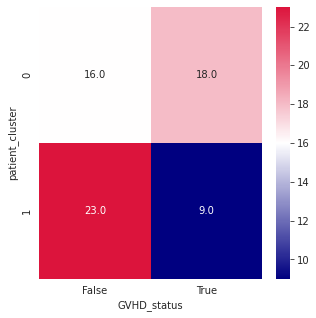

In [124]:
plt.figure(figsize=(5,5))
sns.heatmap(pd.crosstab(patient_cluster,events).loc[[i for i in range(0,2)]],cmap=default_cmap, annot=True, fmt='.1f')

In [219]:
to_plot = []
for i in feature_cluster.unique():
    print(f"Cluster {i}")
    to_plot+=feature_fraction[feature_cluster==i].sort_values(ascending=False)[:20].index.to_list()
    print(feature_fraction[feature_cluster==i].sort_values(ascending=False)[:20])

Cluster Th1 TE, CD4+ TE, CD8+ CM TE EMTM PD-1+
Th1 TE maturity and None expression              1.000000
CD4+ TE maturity and None expression             1.000000
CD8+ CM maturity and PD-1+TIGIT- expression      1.000000
CD8+ TE maturity and PD-1+TIGIT- expression      1.000000
CD8+ CM maturity and PD-1+TIGIT+ expression      1.000000
CD8+ EMTM maturity and PD-1+TIGIT- expression    1.000000
CD8+ EMTM maturity and HLA-DR+ expression        0.954147
CD8+ None maturity and PD-1+TIGIT- expression    0.943184
CD8+ EMTM maturity and TIGIT+ expression         0.941566
CD8+ CM maturity and HLA-DR+ expression          0.923467
CD8+ EMTM maturity and CD226+ expression         0.908822
CD8+ CM maturity and PD-1-TIGIT+ expression      0.873046
CD8+ CM maturity and TIGIT+ expression           0.864423
CD8+ NV maturity and PD-1+TIGIT+ expression      0.856976
CD8+ None maturity and None expression           0.845999
CD8+ TE maturity and None expression             0.825637
CD8+ TE maturity and PD-1

In [147]:
feature_cluster[feature_cluster==0] = 'T helpers Naive, Treg Naive, CD8+ Naive PD-1-TIGIT-'
feature_cluster[feature_cluster==1] = 'Th1 TE, CD4+ TE, CD8+ CM TE EMTM PD-1+'

<AxesSubplot:xlabel='patient_cluster', ylabel='feature_cluster'>

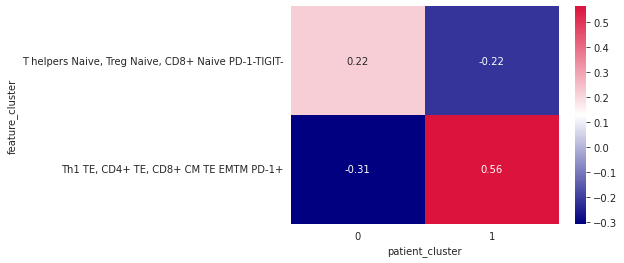

In [150]:
sns.heatmap(x,cmap=default_cmap, annot=True,fmt='.2f')

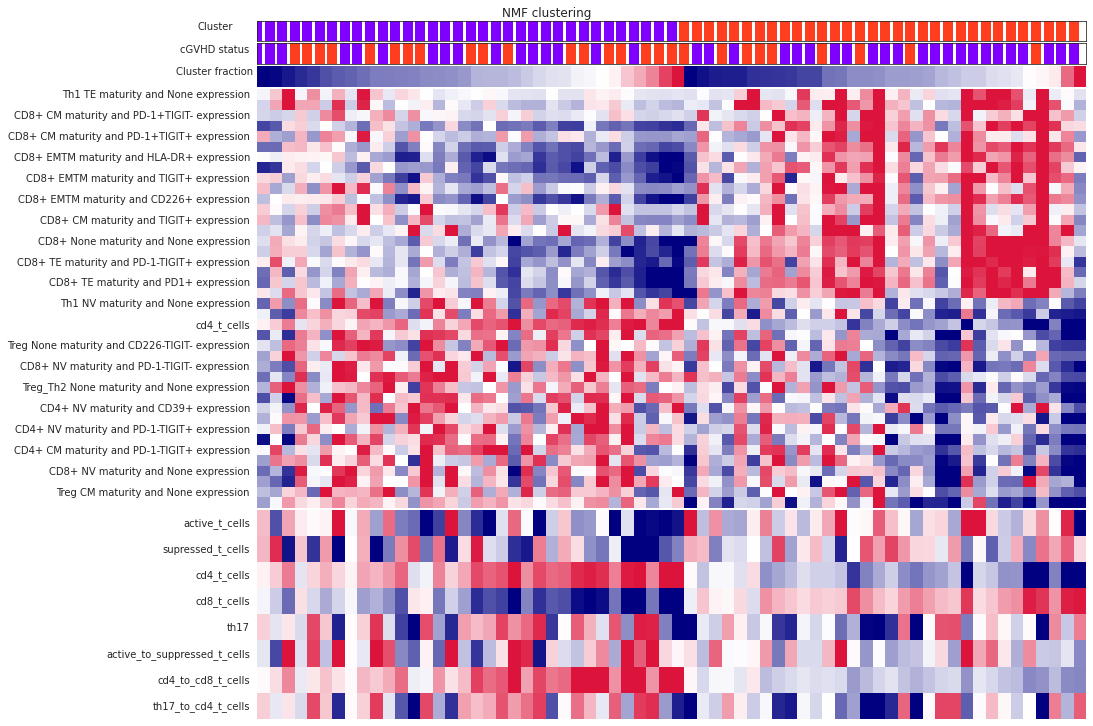

In [260]:
so = sort_by_terms_order(patient_cluster, [i for i in range(0,2)], patient_fraction)

af = axis_matras([.3,.3,.3,6,3],x_len = 15, title = 'NMF clustering', title_y=1)

ax = next(af)
line_palette_annotation_plot(patient_cluster.loc[so],lin_colors(patient_cluster),ax=ax)
ax.set_ylabel('Cluster',rotation=0, labelpad=35             )

ax = next(af)
line_palette_annotation_plot(events.loc[so],lin_colors(events),ax=ax)
ax.set_ylabel('cGVHD status',rotation=0, labelpad=35)


ax = next(af)
x = pd.DataFrame(data=patient_fraction.loc[so], index=so).T
x.index = ['']
sns.heatmap(x,cmap=default_cmap,cbar=False, xticklabels=False,ax=ax)
ax.set_ylabel('Cluster fraction',rotation=0, labelpad=35)

x = median_scale(nmf_data).clip(-2,2).T[so].loc[to_plot]
sns.heatmap(x, ax=next(af),cmap=default_cmap,cbar=False, xticklabels=False)

sns.heatmap((median_scale(populations_united)).clip(-2,2).T[so],ax=next(af),cmap=default_cmap,cbar=False, xticklabels=False)

plt.tight_layout(pad=0.05)
plt.savefig('plots/nmf_select_clustering_heatmap.png',dpi=300, bbox_inches='tight')

In [272]:
patient_cluster[patient_cluster==0] = 'T helpers Naive, Treg Naive, CD8+ Naive PD-1-TIGIT- cluster'
patient_cluster[patient_cluster==1] = 'Th1 TE, CD4+ TE, CD8+ CM TE EMTM PD-1+ cluster'

<AxesSubplot:>

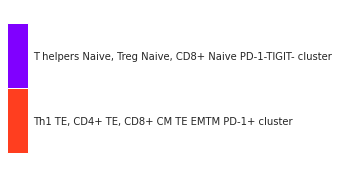

In [273]:
fig,ax = plt.subplots(figsize=(0.4,3))
patch_plot(lin_colors(patient_cluster),ax=ax)
plt.savefig('plots/nmf_select_clustering_heatmap_patient_patch_plot.png',dpi=300, bbox_inches='tight')

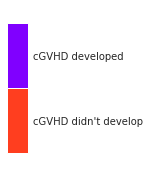

In [274]:
fig,ax = plt.subplots(figsize=(0.4,3))
patch_plot(lin_colors(events.map(lambda x:'cGVHD developed' if x else 'cGVHD didn\'t develop')),ax=ax)
plt.savefig('plots/nmf_select_clustering_heatmap_event_patch_plot.png',dpi=300, bbox_inches='tight')

In [275]:
df_fisher_chi2(patient_cluster, events)

GVHD_status,Fisher_pv,Chi2_pv,False,True
patient_cluster,,,,
"T helpers Naive, Treg Naive, CD8+ Naive PD-1-TIGIT- cluster",0.048731,0.072045,16,18
"Th1 TE, CD4+ TE, CD8+ CM TE EMTM PD-1+ cluster",0.048731,0.072045,23,9


In [278]:
results = pd.concat([patient_cluster,patient_fraction],axis=1)
results.to_csv('NMF_results/patient_clustering.tsv',sep='\t')

results = pd.concat([feature_cluster, feature_fraction],axis=1)
results.to_csv('NMF_results/feature_clustering.tsv',sep='\t')

In [280]:
coef.to_csv('NMF_results/feature_clustering_matrix.tsv',sep='\t')
basis.to_csv('NMF_results/patient_clustering_matrix.tsv',sep='\t')